Download torch and torchvision

In [ ]:
# pip install torch
# pip install timm

In [ ]:
# pip install torchvision

Initialization

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToPILImage
import timm

In [2]:
torch.cuda.empty_cache()

In [3]:
from util import *

In [4]:
USE_GPU = True
dtype = torch.float32 
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    device = torch.device('cpu')
    print("No GPU available. Training will run on CPU.")

GPU: NVIDIA GeForce RTX 4080 is available.


If the output is "using device: cpu": download CUDA toolkit (https://developer.nvidia.com/cuda-downloads)
https://pytorch.org/get-started/locally/

In [ ]:
# data 
random_trans = [v2.ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.2, 0.2)), 
                v2.RandomRotation(degrees=20),
                v2.RandomErasing(p=0.2, scale=(0.05, 0.2), ratio=(0.8, 1.2)), 
                v2.RandomGrayscale(),
                v2.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
                v2.RandomHorizontalFlip(p=0.1)]

transform_train = v2.Compose([v2.ToImage(), 
                              v2.ToDtype(torch.float32, scale=True),
                              v2.Resize(size=235),
                              v2.CenterCrop(size=(224, 224)),
                            #   v2.Normalize([0.4850, 0.4560, 0.4060], [0.2290, 0.2240, 0.2250]),
                              v2.RandomApply(random_trans, 0.5)])

transform_eval = v2.Compose([v2.ToImage(), 
                            v2.ToDtype(torch.float32, scale=True),
                            v2.Resize(size=235),
                            v2.CenterCrop(size=(224, 224)),
                            # v2.Normalize([0.4850, 0.4560, 0.4060], [0.2290, 0.2240, 0.2250])
                            ])

In [6]:
class CropButtonDataset(Dataset):
    def __init__(self, data_dir, transform = None):
        self.data = ImageFolder(data_dir, transform=transform)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index]
    
    # return classes
    def classes(self):
        return self.data.classes

In [7]:
# creat a dictionary that maps index to label
data_dir='../ClassificationDataset_label/train'
target_to_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}

In [8]:
button_train = CropButtonDataset('../ClassificationDataset_label/train', transform=transform_train)
loader_train = DataLoader(button_train, batch_size=45, shuffle=True)

button_val = CropButtonDataset('../ClassificationDataset_label/val', transform=transform_eval)
loader_val = DataLoader(button_val, batch_size=20, shuffle=True)

button_test = CropButtonDataset('../ClassificationDataset_label/test', transform=transform_eval)
loader_test = DataLoader(button_test, batch_size=14, shuffle=False)

Check If load correctly

In [9]:
loader_train

In [10]:
for images, labels in loader_val:
    print("Batch loaded!")
    print("Images shape:", images.shape)
    print("Labels:", labels)
    break


Batch loaded!
Images shape: torch.Size([20, 3, 224, 224])
Labels: tensor([0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0])


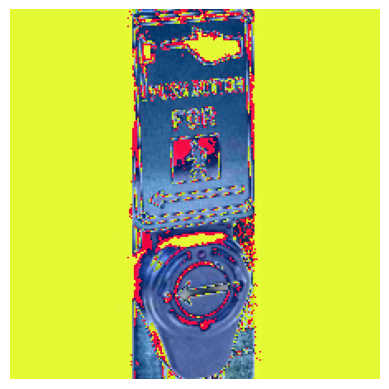

In [11]:
tensor_img = images[0]

to_pil = ToPILImage()
pil_img = to_pil(tensor_img.cpu())  

plt.imshow(pil_img)
plt.axis('off')
plt.show()

Model setup

In [12]:
class Resnet18BinaryClassifier(nn.Module):
    def __init__(
        self,
        backbone_name: str = 'resnet18.a1_in1k',
        hidden_dim: int = 512,
        dropout_prob: float = 0.5,
    ):
        """
        Param:
            - backbone_name: Hugging Face Dinov2 
            - hidden_dim: hidden dim
            - dropout_prob: dropout ratio
        """
        super().__init__()
        # 1) Load pretrained ResNet18 backbone (no classifier head)
        self.backbone = timm.create_model(backbone_name, pretrained=True, num_classes=0)

        # 2) Classification Head
        self.classifier = nn.Sequential(
            nn.Linear(self.backbone.num_features, hidden_dim),  # get output dim from backbone
            nn.ReLU(),
            nn.Dropout(p=dropout_prob),
            nn.Linear(hidden_dim, 1),  # binary output
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.classifier(x)
        return x

Check augmentation

In [13]:
# import timm
# from timm.data import resolve_data_config, create_transform

# model = timm.create_model('resnet18.a1_in1k', pretrained=True)
# config = resolve_data_config({}, model=model)
# transform = create_transform(**config)


In [14]:
# transform

test backbone

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model
model = Resnet18BinaryClassifier().to(device)

dummy_images = torch.randn(2, 3, 224, 224).to(device)  # (B=2, C=3, H=224, W=224)

with torch.no_grad():
    logits = model(dummy_images)

print("Logits:", logits)
probs = torch.softmax(logits, dim=-1)
print("Probabilities:", probs)

Logits: tensor([[0.1367],
        [0.1029]], device='cuda:0')
Probabilities: tensor([[1.],
        [1.]], device='cuda:0')


Find best hyperparameter

In [16]:
# arch = ('resnet18.a1_in1k', 512, 0.5)
# best_model, best_params, best_training_data, top_5 = hyperparameter_search(Resnet18BinaryClassifier, arch, loader_train, loader_val, device, 10)

In [17]:
# print(top_5[0][2])
# print(top_5[1][2])
# print(top_5[2][2])
# print(top_5[3][2])
# print(top_5[4][2])
# {'lr': 0.00521730000802764, 'weight_decay': 0.0028308734639643156, 'betas': (0.9, 0.98)}
# {'lr': 0.0012611030853025141, 'weight_decay': 0.003273638255942151, 'betas': (0.95, 0.999)}
# {'lr': 0.0003153170184196531, 'weight_decay': 0.007258787676243973, 'betas': (0.95, 0.999)}
# {'lr': 0.0003327784642253482, 'weight_decay': 0.0007883375177606448, 'betas': (0.9, 0.98)}
# {'lr': 6.857439481016142e-05, 'weight_decay': 0.0007883375177606448, 'betas': (0.9, 0.98)}

In [18]:
# plotpic(best_training_data)

In [19]:
# check_accuracy_final(loader_test, best_model, True)

Train best model

In [26]:
final_model = Resnet18BinaryClassifier(hidden_dim=512, dropout_prob=0.5)

In [27]:
from torchinfo import summary
summary(final_model, input_size=(1, 3, 320, 320))

Layer (type:depth-idx)                        Output Shape              Param #
Resnet18BinaryClassifier                      [1, 1]                    --
├─ResNet: 1-1                                 [1, 512]                  --
│    └─Conv2d: 2-1                            [1, 64, 160, 160]         9,408
│    └─BatchNorm2d: 2-2                       [1, 64, 160, 160]         128
│    └─ReLU: 2-3                              [1, 64, 160, 160]         --
│    └─MaxPool2d: 2-4                         [1, 64, 80, 80]           --
│    └─Sequential: 2-5                        [1, 64, 80, 80]           --
│    │    └─BasicBlock: 3-1                   [1, 64, 80, 80]           73,984
│    │    └─BasicBlock: 3-2                   [1, 64, 80, 80]           73,984
│    └─Sequential: 2-6                        [1, 128, 40, 40]          --
│    │    └─BasicBlock: 3-3                   [1, 128, 40, 40]          230,144
│    │    └─BasicBlock: 3-4                   [1, 128, 40, 40]          295,42

In [28]:
# hard code best paramm
lr = 6.857439481016142e-05
wd= 0.0007883375177606448
beta = (0.9, 0.98)

In [29]:
optimizer = torch.optim.AdamW(
            [
                {"params": final_model.backbone.parameters(), "lr": lr / 10},
                {"params": final_model.classifier.parameters(), "lr": lr * 10},
            ],
            weight_decay=wd,
            betas= beta)
data = train(final_model, optimizer, loader_train, loader_val, device, earlystop = True, patience=30, delta=0.01, epochs=30)

Iter: 1/90    |  Loss: 0.701885  |  Train Acc: 0.5385  |  Val Acc: 0.5000 
Sample preds : [45.2%, 45.2%, 45.8%, 42.5%, 43.7%, 46.0%, 45.8%, 43.3%, 45.9%, 45.3%, 45.4%, 46.4%, 43.3%, 45.2%, 44.7%, 45.6%, 44.6%, 46.6%, 43.5%, 46.2%]
Sample labels: [1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0]
Iter: 2/90    |  Loss: 0.691456  |  Train Acc: 0.5495  |  Val Acc: 0.5000 
Iter: 3/90    |  Loss: 0.948016  |  Train Acc: 0.5495  |  Val Acc: 0.5000 
Sample preds : [46.1%, 44.3%, 47.9%, 46.0%, 46.5%, 43.6%, 46.0%, 47.9%, 46.9%, 47.5%, 47.4%, 47.8%, 44.9%, 46.9%, 48.0%, 47.2%, 46.5%, 45.9%, 47.1%, 46.1%]
Sample labels: [0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0]
Iter: 4/90    |  Loss: 0.683345  |  Train Acc: 0.5604  |  Val Acc: 0.5000 
Iter: 5/90    |  Loss: 0.697753  |  Train Acc: 0.5495  |  Val Acc: 0.5000 
Sample preds : [50.8%, 49.9%, 50.1%, 49.5%, 50.4%, 49.2%, 48.4%, 49.6%, 48.1%, 46

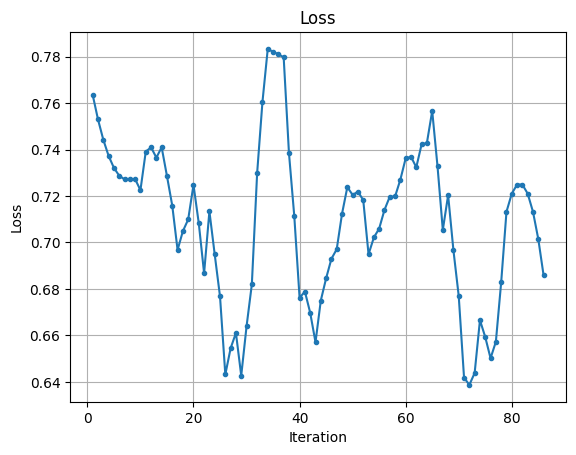

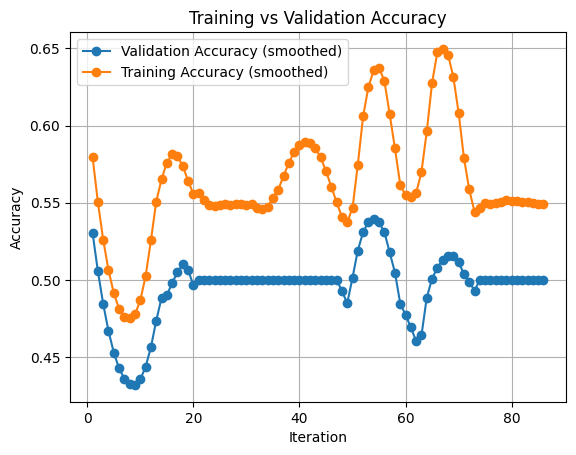

In [30]:
plotpic(data, smooth_window=15)

In [31]:
check_accuracy_final(loader_test, final_model, device, out=True)

Sample preds : [38.6%, 44.5%, 41.4%, 40.4%, 44.5%, 45.3%, 46.9%, 40.8%, 40.7%, 47.0%, 44.6%, 51.4%, 42.9%, 41.9%]
Sample labels: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


0.5714285714285714

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

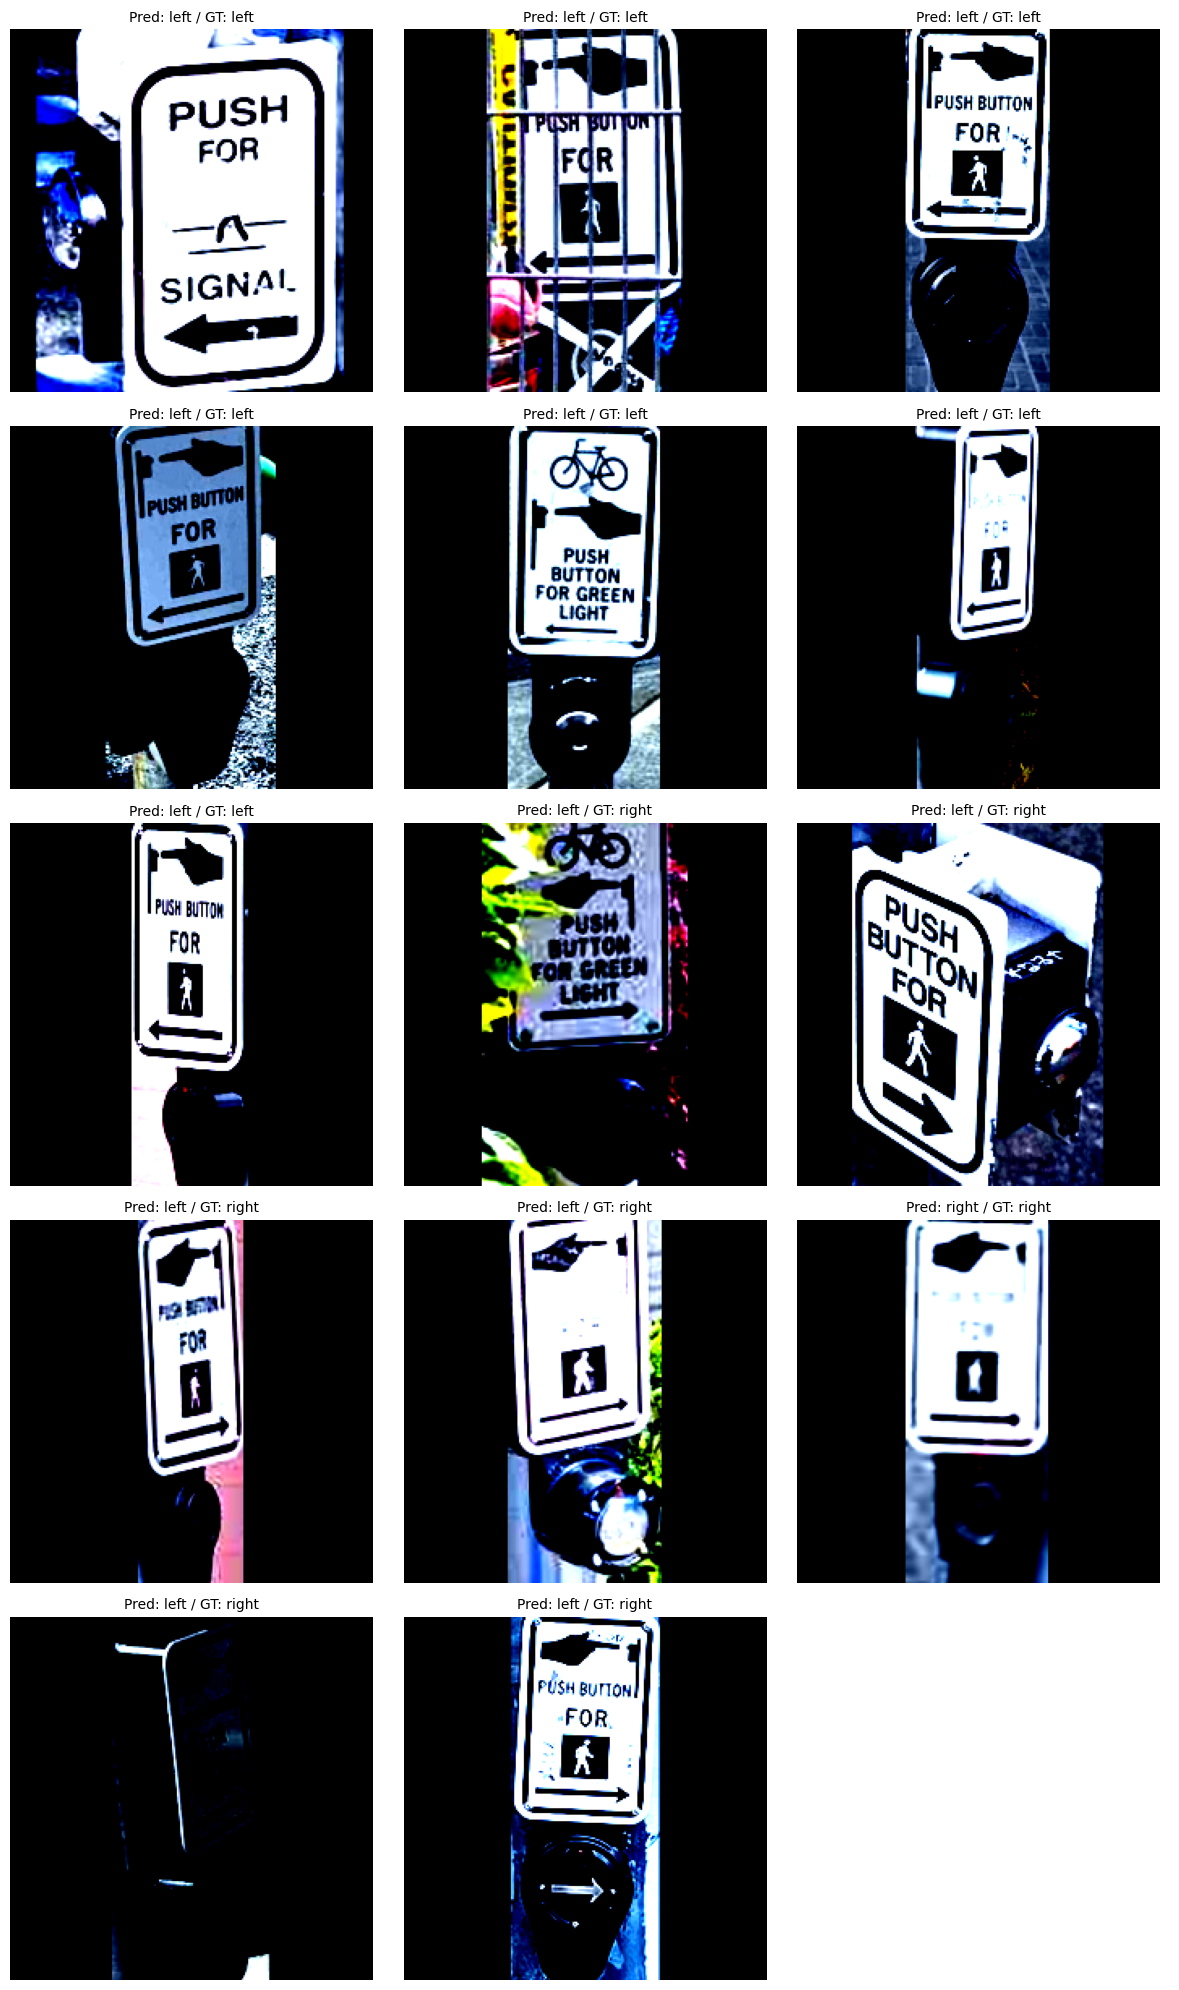

In [32]:
show_predictions_grid(loader_test, final_model, device, class_names=['left', 'right'], max_images=14, images_per_row=3)

Save model

In [ ]:
torch.save(final_model.state_dict(), "Resnet18.pth")